In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

##### Read the data

In [2]:
PATH = 'data'

one_p = np.abs(np.loadtxt(f'{PATH}/1p.csv', dtype=np.complex128))
two_p = np.abs(np.loadtxt(f'{PATH}/2p.csv', dtype=np.complex128))
three_p = np.abs(np.loadtxt(f'{PATH}/3p.csv', dtype=np.complex128))
empty = np.abs(np.loadtxt(f'{PATH}/empty.csv', dtype=np.complex128))
print(f"one_p.shape: {one_p.shape}")
print(f"two_p.shape: {two_p.shape}")
print(f"three_p.shape: {three_p.shape}")
print(f"empty.shape: {empty.shape}")


one_p.shape: (60, 61440)
two_p.shape: (60, 61440)
three_p.shape: (80, 61440)
empty.shape: (40, 61440)


In [3]:
one_p = one_p.reshape(one_p.shape[0]* 5, 3, 64, 64)
two_p = two_p.reshape(two_p.shape[0]* 5, 3, 64, 64)
three_p = three_p.reshape(three_p.shape[0]* 5, 3, 64, 64)[100:, :, :, :]
empty = empty.reshape(empty.shape[0]* 5, 3, 64, 64)

print(f"one_p.shape: {one_p.shape}")
print(f"two_p.shape: {two_p.shape}")
print(f"three_p.shape: {three_p.shape}")
print(f"empty.shape: {empty.shape}")


one_p.shape: (300, 3, 64, 64)
two_p.shape: (300, 3, 64, 64)
three_p.shape: (300, 3, 64, 64)
empty.shape: (200, 3, 64, 64)


In [10]:
import cv2
def normalize_data(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def calculate_saliency_map(frames):
    new_frames = []
    for frame in frames:
        mean = np.mean(frame)
        frame_new = np.where(frame>mean, frame, 0)
        new_frames.append(frame_new)
    new_frames = np.array(new_frames)
    frames = new_frames
    frames[:,32,:] = 0
    differences = np.abs(np.diff(frames, axis=0))
    multiplications = []
    for i in range(differences.shape[0]-1):
        multiplications.append(np.multiply(differences[i], differences[i+1]))
    multiplications = np.asarray(multiplications)

    multiplications = differences
    morph = np.array(
        [cv2.morphologyEx(img, cv2.MORPH_OPEN, np.ones((3, 3))) for img in multiplications]
    )

    saliency_map_morph = np.expand_dims(np.sum(morph, axis=0), axis = 0)
    saliency_map = np.expand_dims(np.sum(multiplications, axis=0), axis = 0)
    return normalize_data(saliency_map) #normalize_data(saliency_map_morph)

def plot_saliency_map(saliency_map):
    fig, axs = plt.subplots(1, len(saliency_map), figsize=(15, 5), sharex=True, sharey=True)
    fig.suptitle("Range-Doppler Plot")
    for i in range(1):
        if len(saliency_map) == 1:
            to_plot = saliency_map[0, :, :]
            pos = axs.imshow(to_plot)
            fig.colorbar(pos, ax=axs)
        else:
            for j in range(len(saliency_map)):
                to_plot = saliency_map[j, :, :] 
                pos = axs[j].imshow(to_plot)
                axs[j].set_aspect("equal")
                #fig.colorbar(pos, ax=axs[j])

(10, 64, 64)


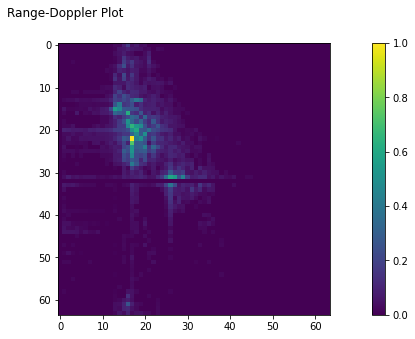

In [13]:
from scipy import signal
idx = 20
sample = two_p[idx:idx+10].squeeze()
sample = np.sum(sample, axis = 1).squeeze()
print(sample.shape)
saliency_map = calculate_saliency_map(sample)

plot_saliency_map(saliency_map)


In [42]:
print(saliency_map[0].shape)
vel = np.sum(saliency_map[1].squeeze(), axis = 1)
dist = np.sum(saliency_map[1].squeeze(), axis = 0)

plt.plot(vel)
fig = plt.figure()
plt.plot(dist)

(64, 64)


IndexError: index 1 is out of bounds for axis 0 with size 1

(3, 64)
(3, 64)
(1, 64)


IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

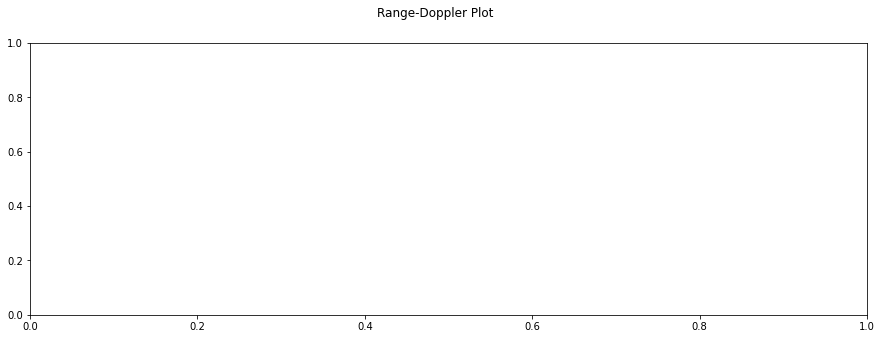

In [43]:
sample = two_p[26].squeeze()
sample = np.sum(sample, axis = 1).squeeze()
print(sample.shape)
saliency_map = calculate_saliency_map(sample)
print(saliency_map.shape)
plot_saliency_map(saliency_map)

In [ ]:
sample = three_p[15].squeeze()
sample = np.sum(sample, axis = 1).squeeze()
print(sample.shape)
saliency_map = calculate_saliency_map(sample)
print(saliency_map.shape)
plot_saliency_map(saliency_map)

(3, 64)
(3, 64)


AttributeError: 'tuple' object has no attribute 'shape'

In [ ]:
sample = three_p[35].squeeze()
sample = np.sum(sample, axis = 1).squeeze()
print(sample.shape)
diffs = np.diff(sample, axis=0)
print(diffs.shape)
fig, axs = plt.subplots(1, 5, figsize=(15, 5), sharex=True, sharey=True)
fig.suptitle("Range-Doppler Plot")
for i in range(1):
    for j in range(5):
        to_plot = np.abs(sample)[j, :, :] >1
        axs[j].imshow(to_plot)
        axs[j].set_aspect("equal")

(32, 1)


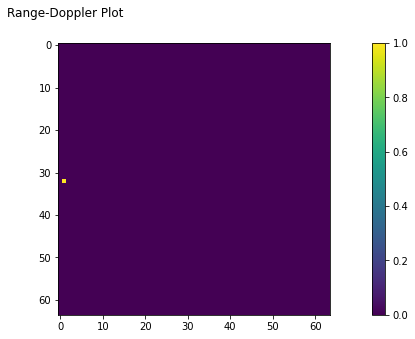

In [48]:
maps = []

for sample in empty:
    sample_empty = np.sum(sample, axis = 0).squeeze()
    saliency_map_empty = sample_empty #calculate_saliency_map(sample_empty)
    saliency_map_empty = saliency_map_empty / np.linalg.norm(saliency_map_empty)
    maps.append(saliency_map_empty.squeeze())
maps = np.asarray(maps)
noise = np.sum(maps, axis=0)
noise = noise / np.linalg.norm(noise)
noise = noise > 0.5
index_max = np.unravel_index(np.argmax(noise), np.array(noise).shape)
print(index_max)
radius = 3
noise[index_max[0]-radius:index_max[0]+radius,  index_max[1]-radius:index_max[1]+radius] = 1
plot_saliency_map(np.expand_dims(noise, axis=0))

In [ ]:
sample_one = one_p[20].squeeze()
sample_one = np.sum(sample_one, axis = 1).squeeze()
print(sample_one.shape)
saliency_map_one = calculate_saliency_map(sample_one)
saliency_map_one = saliency_map_one / np.linalg.norm(saliency_map_one)
plot_saliency_map(saliency_map_one)
diff = saliency_map_one - noise
diff = np.where(diff>0, diff, 0)
print(np.min(diff))
plot_saliency_map(diff)
